## 2d van de vusse

A -> B -> C  

### Imports

In [1]:
from __future__ import division
import scipy as sp
import scipy.spatial
import scipy.linalg
import matplotlib.pyplot as plt
import sympy

plt.style.use('ggplot')
% matplotlib inline

# artools package
import sys
sys.path.append('C:\Users\deanzimucha\Dropbox\MSc\scripts')
import artools
artools = reload(artools)

### Define stoichiometric coefficient matrix

In [2]:
stoich_mat = sp.array([[-1., 1., 0.], [0., -1., 1.]]).T

### What is the dimension of the stoichiometric subspace?
- rank(A)

In [3]:
rank_A = artools.rank(stoich_mat)
rank_A

2

### Are the reactions linearly independent?
- Any non zero 1-dimensional vector (hyperplane) that produces the zero vector when multiplied to the stoichiometric matrix such that `Ax = 0` belongs to the nullspace
- If the nullspace is 'empty' then all the columnns in A are linearly independent
- If there exists a non zero vector in the nullspace then some of the columns in A are linearly dependent

In [4]:
nullspace_A = artools.nullspace(stoich_mat)
nullspace_A

array([], shape=(2L, 0L), dtype=float64)

### Plot the concentration space achievable by stoichiometry

C:\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


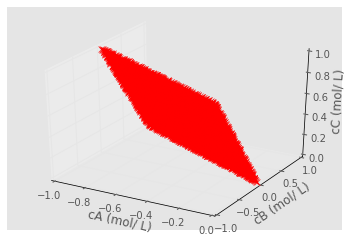

In [5]:
# matrix of linear combinations in extent space 
E = sp.rand(2, 10000)

# plane representing stoichiometric subspace 
AE_mat = sp.dot(stoich_mat, E)

# plot
# A-B-C space
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
plt.hold(True)

plt.plot(AE_mat[0, :], AE_mat[1, :], AE_mat[2, :], 'rx')

# label
ax1.set_xlabel('cA (mol/ L)')
ax1.set_ylabel('cB (mol/ L)')
ax1.set_zlabel('cC (mol/ L)')

plt.show(fig1)

### define reaction kinetics

In [6]:
def rate_func(C, t):
    """determine rate vector from a given set of rate kinetics"""
    
    # declare concentration variables
    cA = C[0]
    cB = C[1]
    # cC = C[2]
    
    # rate constants  
    k1 = 1.0              
    k2 = 1.0
    k3 = 10.0
    
    # define rate vector
    # rate vector = [rA, rB, rC, rD]  (mol/L.s)
    R = sp.array([-k1*cA - 2*k3*cA**2,
                    k1*cA - k2*cB,
                    k2*cB]);
    return R  

### plot rate field

#### Which space am I looking at?
- 2 independent reactions participating, therefore the stoichiometric subspace is 2 dimensional.
- A-B space since the kinetics are only affected by the molar concentrations of A and B

C:\Anaconda2\lib\site-packages\matplotlib\quiver.py:625: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Anaconda2\lib\site-packages\matplotlib\quiver.py:625: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Anaconda2\lib\site-packages\matplotlib\quiver.py:681: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
C:\Anaconda2\lib\site-packages\matplotlib\quiver.py:691: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


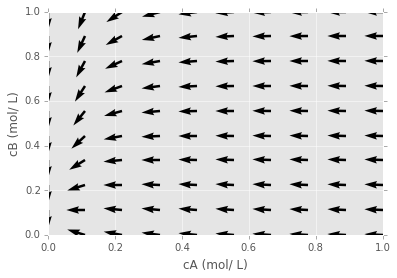

In [7]:
e1 = sp.linspace(0, 1, num=10)
e2 = sp.linspace(0, 1, num=10)

# plot 
fig2 = plt.figure()
ax2 = fig2.gca()
plt.hold(True)

for xi in e1:
    for yi in e2:
        ci = sp.array([xi, yi])
        ri = rate_func(ci, 1)
        
        ax2.quiver(xi, yi, ri[0], ri[1])
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.set_xlabel('cA (mol/ L)')
        ax2.set_ylabel('cB (mol/ L)')
        
plt.show(fig2)

### define feed material

In [8]:
Cf1 = sp.array([1., 0., 0.])
Cf2 = sp.array([1., 1., 0.])
Cf3 = sp.array([1., 1., 1.])
Cf0s = sp.array(([Cf1, Cf2, Cf3]))

### Are the feeds linearly independent 

In [9]:
nullspace_Cf0s = artools.nullspace(Cf0s)
nullspace_Cf0s

array([], shape=(3L, 0L), dtype=float64)

### Prove independence using rref()
- If the reduced row echelon form of the feeds matrix matches the identity matrix then all the columns (feeds) are independent
- a row of zeros indicates dependence

In [10]:
G, h = sympy.Matrix(Cf0s).rref()
G

Matrix([
[1.0,   0,   0],
[  0, 1.0,   0],
[  0,   0, 1.0]])

### define constants

In [11]:
# define PFR integration range
pfr_ts = sp.logspace(sp.log10(1e-5), sp.log10(10), num=50)

# define no. of points to generate in the complement region 
num_pts = 1e+3

## Multiple-feed algorithm 

### Initialization:

1. find the stoichiometric subspace
2. generate an initial region of achievable points within the stoichiometric subspace  

In [12]:
def stoich_subspace(Cf, stoich_mat):
    """ 
    Find stoichiometric subspace, S, from a single feed 
	and reaction stoichoimetry
 
     Parameters:
         Cf            feed material
         stoich_mat    stoichiometric coefficient matrix
         
     Returns:
         S_attributes  dictionary containing attributes 

    """

    # create an empty list of bounds/ axis_lims
    min_lims = []
    max_lims = []

    # to store S_attributes dictionary
    S_attributes = {}

    # to store vertices for each feed and stoich_mat in extent and concentration space
    all_Es = []
    all_Cs = []

    # Check if Cf is a column vector 
    # with ndim=2, or a (L,) array with ndim=1 only
    if Cf.ndim == 2:
        Cf = Cf.flatten()  # converts into (L,)

        # raise an error if the no. of components is inconsistent between the feed and stoichiometric matrix
    if len(Cf) != stoich_mat.shape[0]:
        raise Exception(
            "The number of components in the feed does not match the number of rows in the stoichiometric matrix.")

        # always treat stoich_mat as a matrix for consistency, convert if not
    if stoich_mat.ndim == 1:
        # converts a 'single rxn' row into column vector
        stoich_mat = stoich_mat.reshape((len(stoich_mat), 1))

    # check if  a single reaction or multiple reactions are occuring
    if stoich_mat.shape[1] == 1 or stoich_mat.ndim == 1:
        # if stoich_mat is (L,) array this'stoich_mat.shape[1]' raises an error 'tuple out of range'

        # converts into (L,)
        stoich_mat = stoich_mat.flatten()

        # calculate the limiting requirements
        limiting = Cf / stoich_mat

        # only choose negative coefficients as these indicate reactants
        k = limiting < 0.0

        # calc maximum extent based on limiting reactant and calc C
        # we take max() because of the negative convention of the limiting requirements
        e_max = sp.fabs(max(limiting[k]))

        # calc the corresponding point in concentration space
        C = Cf + stoich_mat * e_max

        # form Cs and Es and return
        Cs = sp.vstack([Cf, C])
        Es = sp.array([[0., e_max]]).T

    else:
        # extent associated with each feed vector
        Es = artools.con2vert(-stoich_mat, Cf)

        # calc the corresponding point in concentration space
        Cs = (Cf[:, None] + sp.dot(stoich_mat, Es.T)).T

    # vertices for each feed and stoich_mat in extent and concentration space
    all_Es.append(Es)
    all_Cs.append(Cs)

    # stack vertices in one list and find the overall stoichiometric subspace(convex hull)
    all_Es_mat = sp.vstack(all_Es)
    all_Cs_mat = sp.vstack(all_Cs)

    # define no. of components in the system
    N = stoich_mat.shape[0]

    # create a matrix of indices of components in the system
    components = sp.linspace(0, N - 1, num=N)

    for i in components:
        # loop through each component and find the (min, max) => bounds of the axis
        minMatrix = min(all_Cs_mat[:, i])
        maxMatrix = max(all_Cs_mat[:, i])

        # append limits into preallocated lists (min_lims, max_lims)
        min_lims.append(minMatrix)
        max_lims.append(maxMatrix)

        # stack them into an ndarray and flatten() into a row vector
        bounds = sp.vstack((min_lims, max_lims)).T
        bounds = bounds.flatten()  # alternating min, max values

    # create a dictionary containing all the 'attributes' of the 'stoich_subspace'
    S_attributes = {
        'all_Es': all_Es,
        'all_Cs': all_Cs,
        'all_Es_mat': all_Es_mat,
        'all_Cs_mat': all_Cs_mat,
        'bounds': bounds
    }

    return S_attributes

# call function stoich_subspace() from artools package 
S_attributes = stoich_subspace(Cf1, stoich_mat)

# find stoichiometric subspace
S = S_attributes['all_Cs_mat']

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:88: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:89: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [13]:
S, S.shape

(array([[  0.00000000e+00,   1.11022302e-16,   1.00000000e+00],
        [  1.00000000e+00,   5.55111512e-17,  -5.55111512e-17],
        [  0.00000000e+00,   1.00000000e+00,   0.00000000e+00]]), (3L, 3L))

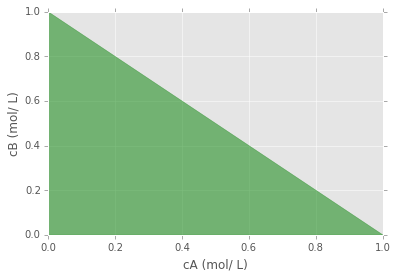

In [14]:
fig3 = artools.plot_region2d(S[:, (0, 1)])
ax3 = fig3.gca()
plt.hold(True)

# label
ax3.set_xlabel('cA (mol/ L)')
ax3.set_ylabel('cB (mol/ L)')

plt.show(fig3)

### define function to find initial region Po
- only PFR trjectories are used to generate the initial region

In [15]:
def initial_region(rate_func, Cf, pfr_ts):
    '''
    find initial candidate region by running PFRs from multiple feed points
    
    parameters:
        Cf                 feed matrix
        rate_func          reaction rate kinetics 
        pfr_ts             PFR integration range 
        
    returns:
        Po                 initial region in concentration space
        pfr_cs             PFR solution trajectories from multiple feed points 
        Xo, zo             H-representation (hyperplanes) of the inital region                 
        
    '''
        
    # find pfr solution trajectory from Cf
    pfr_soln = sp.integrate.odeint(rate_func, Cf, pfr_ts) 
        
    # collapse list into an array
    initial_region = sp.vstack((pfr_soln))
    
    # H-representation of the initial region 
    Xo, zo = artools.vert2con(initial_region[:, (0,1)])
    
    # define dictionary Po_attributes 
    Po_attributes = {
        'Po' : initial_region,
        'pfr_cs' : pfr_soln,
        }
    
    return Po_attributes

# call function 
# find initial region  
Po_attributes = initial_region(rate_func, Cf1, pfr_ts)     
Po = Po_attributes['Po']
pfr_cs = Po_attributes['pfr_cs']

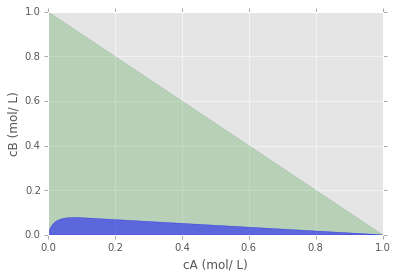

In [16]:
# slice 
Po = Po[:, (0, 1)]
S = S[:, (0, 1)]

fig3 = artools.plot_region2d(S, alpha=0.2)
ax3 = fig3.gca()
fig4 = artools.plot_region2d(Po, color='b', ax=ax3)
plt.hold(True)

# label
ax3.set_xlabel('cA (mol/ L)')
ax3.set_ylabel('cB (mol/ L)')

plt.show(fig3)

### Growth Phase 
1. generate N points in complement space
2. find rate vector at each point 
3. check for feasibility - intersections with the current region 

In [17]:
# define find_ar
def find_ar(A, b, Pk, num_pts, axis_lims, tol):
    '''
    find NEW achievable points in the complement space based on the current
    region.

    parameters:
        A, b               H-representation of the stoichiometric subspace 
        Pk                 candidate AR at iteration k=0
        num_pts            no. of points to find in the complement space
        axis_lims          bounds of the stoichiometric subspace

    returns:
        new_pts            achievable points in the complement space 
        ts                 corresponding residence times 
    '''

    # pts in complement space
    cmp_pts = []
    
    # preallocate memory to store feasible residence times 
    ts = []

    # preallocate memory to store the indices of the new feasible points 
    idk = []

    # H-representation for the current polytope Pk
    Q, z = artools.vert2con(Pk[:, (0,1)])

    # Execute while the no. of points within S is less than a set no. of points 
    while (len(cmp_pts)<num_pts):

        # track progress for one iteration 
        print ('%.2f %%\tcomplete!') % (float(len(cmp_pts))/float(num_pts)*100)

        # generate random points
        rnd_pts = artools.rand_pts(num_pts, axis_lims[0:4])

        # loop through random points
        # find points in the complement regon
        # append to cmp_pts
        for rnd in rnd_pts:

            if artools.out_region(rnd, Q, z) and artools.in_region(rnd, A, b):
                # if the random point is inside the stoichiometric subspace and 
                # outside the candidate region at the current iteration

                # append to list
                cmp_pts.append(rnd)

    # stack random points into one array and reassign it to the variable cmp_pts
    cmp_pts = sp.vstack(cmp_pts)

    # loop through cmp_pts
    # check for intersections with the candidate region at the current iteration 
    for i, ci in enumerate(cmp_pts):

        # calc rate vector
        ri = rate_func(ci, 1) 

        # instantaneous residence time
        tvec = (sp.dot(Q, ci) - z) / (sp.dot(Q, ri[[0,1]]))

        # loop through each resident time in tvec
        for ti in tvec:
            
            # take on positive residence times 
            if ti >= 0:
                
                # compute intersection point xi
                xi = ci - sp.dot(ti, ri[[0,1]])
                
                # is Q*xi <= z? (i.e. is xi in Pk?)
                if sp.all(sp.dot(Q, xi) - z <= tol):
                    
                    # append feasible indices
                    idk.append(i)
                    
                    # append corresponding residence times
                    ts.append(ti)
                    break
                
    # compute achievable points
    new_pts = cmp_pts[idk, :]
    
    return new_pts, ts

### Convergence

In [18]:
# Pk only contains the initial region Po at the 1st iteration 
Pk = Po

# define axis limits
axis_lims = S_attributes['bounds']

# H-representation for stoichiometric subspace S
# From this point, we work in A-B concentration space 
A, b = artools.vert2con(S)

# define tolerance for check points in current region
tol = 1e-6

# define iteration identity value 
iterate = 0.

# define no.of iterations in loop
while (iterate<100):
    
    iterate = iterate + 1
    
    print ('\n iteration: %.f \n') % (iterate)    
    
    # find points in complement space 
    new_pts, ts = find_ar(A, b, Pk, num_pts, axis_lims, tol)
    
    Pk = sp.concatenate((Pk, new_pts))


 iteration: 1 

0.00 %	complete!
45.40 %	complete!
87.00 %	complete!

 iteration: 2 

0.00 %	complete!
44.60 %	complete!
92.00 %	complete!

 iteration: 3 

0.00 %	complete!
46.70 %	complete!
90.90 %	complete!

 iteration: 4 

0.00 %	complete!
45.10 %	complete!
88.80 %	complete!

 iteration: 5 

0.00 %	complete!
43.10 %	complete!
88.70 %	complete!

 iteration: 6 

0.00 %	complete!
44.60 %	complete!
89.70 %	complete!

 iteration: 7 

0.00 %	complete!
47.20 %	complete!
93.70 %	complete!

 iteration: 8 

0.00 %	complete!
45.10 %	complete!
88.80 %	complete!

 iteration: 9 

0.00 %	complete!
43.00 %	complete!
89.50 %	complete!

 iteration: 10 

0.00 %	complete!
46.60 %	complete!
92.30 %	complete!

 iteration: 11 

0.00 %	complete!
44.60 %	complete!
90.20 %	complete!

 iteration: 12 

0.00 %	complete!
45.00 %	complete!
87.60 %	complete!

 iteration: 13 

0.00 %	complete!
46.20 %	complete!
90.30 %	complete!

 iteration: 14 

0.00 %	complete!
45.10 %	complete!
91.50 %	complete!

 iteration: 15

In [19]:
# preallocate memory to store single feed candidate ARs 
PK_mat = []

for Cf in Cf0s:
    #==============================================================================
    # Initialization:
    #
    # 1. find the stoichiometric subspace
    # 2. generate an initial region of achievable points 
    #    within the stoichiometric subspace  
    #==============================================================================
    def stoich_subspace(Cf, stoich_mat):
        """ 
        Find stoichiometric subspace, S, from a single feed 
    	and reaction stoichoimetry
     
         Parameters:
             Cf            feed material
             stoich_mat    stoichiometric coefficient matrix
             
         Returns:
             S_attributes  dictionary containing attributes 
    
        """
    
        # create an empty list of bounds/ axis_lims
        min_lims = []
        max_lims = []
    
        # to store S_attributes dictionary
        S_attributes = {}
    
        # to store vertices for each feed and stoich_mat in extent and concentration space
        all_Es = []
        all_Cs = []
    
        # Check if Cf is a column vector 
        # with ndim=2, or a (L,) array with ndim=1 only
        if Cf.ndim == 2:
            Cf = Cf.flatten()  # converts into (L,)
    
            # raise an error if the no. of components is inconsistent between the feed and stoichiometric matrix
        if len(Cf) != stoich_mat.shape[0]:
            raise Exception(
                "The number of components in the feed does not match the number of rows in the stoichiometric matrix.")
    
            # always treat stoich_mat as a matrix for consistency, convert if not
        if stoich_mat.ndim == 1:
            # converts a 'single rxn' row into column vector
            stoich_mat = stoich_mat.reshape((len(stoich_mat), 1))
    
        # check if  a single reaction or multiple reactions are occuring
        if stoich_mat.shape[1] == 1 or stoich_mat.ndim == 1:
            # if stoich_mat is (L,) array this'stoich_mat.shape[1]' raises an error 'tuple out of range'
    
            # converts into (L,)
            stoich_mat = stoich_mat.flatten()
    
            # calculate the limiting requirements
            limiting = Cf / stoich_mat
    
            # only choose negative coefficients as these indicate reactants
            k = limiting < 0.0
    
            # calc maximum extent based on limiting reactant and calc C
            # we take max() because of the negative convention of the limiting requirements
            e_max = sp.fabs(max(limiting[k]))
    
            # calc the corresponding point in concentration space
            C = Cf + stoich_mat * e_max
    
            # form Cs and Es and return
            Cs = sp.vstack([Cf, C])
            Es = sp.array([[0., e_max]]).T
    
        else:
            # extent associated with each feed vector
            Es = artools.con2vert(-stoich_mat, Cf)
    
            # calc the corresponding point in concentration space
            Cs = (Cf[:, None] + sp.dot(stoich_mat, Es.T)).T
    
        # vertices for each feed and stoich_mat in extent and concentration space
        all_Es.append(Es)
        all_Cs.append(Cs)
    
        # stack vertices in one list and find the overall stoichiometric subspace(convex hull)
        all_Es_mat = sp.vstack(all_Es)
        all_Cs_mat = sp.vstack(all_Cs)
    
        # define no. of components in the system
        N = stoich_mat.shape[0]
    
        # create a matrix of indices of components in the system
        components = sp.linspace(0, N - 1, num=N)
    
        for i in components:
            # loop through each component and find the (min, max) => bounds of the axis
            minMatrix = min(all_Cs_mat[:, i])
            maxMatrix = max(all_Cs_mat[:, i])
    
            # append limits into preallocated lists (min_lims, max_lims)
            min_lims.append(minMatrix)
            max_lims.append(maxMatrix)
    
            # stack them into an ndarray and flatten() into a row vector
            bounds = sp.vstack((min_lims, max_lims)).T
            bounds = bounds.flatten()  # alternating min, max values
    
        # create a dictionary containing all the 'attributes' of the 'stoich_subspace'
        S_attributes = {
            'all_Es': all_Es,
            'all_Cs': all_Cs,
            'all_Es_mat': all_Es_mat,
            'all_Cs_mat': all_Cs_mat,
            'bounds': bounds
        }
    
        return S_attributes
    
    # define function to find initial region Po
    # only PFR trjectories are used to generate the initial region
    def initial_region(rate_func, Cf, pfr_ts):
        '''
        find initial candidate region by running PFRs from multiple feed points
        
        parameters:
            Cf                 feed matrix
            rate_func          reaction rate kinetics 
            pfr_ts             PFR integration range 
            
        returns:
            Po                 initial region in concentration space
            pfr_cs             PFR solution trajectories from multiple feed points 
            Xo, zo             H-representation (hyperplanes) of the inital region                 
            
        '''
            
        # find pfr solution trajectory from Cf
        pfr_soln = sp.integrate.odeint(rate_func, Cf, pfr_ts) 
            
        # collapse list into an array
        initial_region = sp.vstack((pfr_soln))
        
        # H-representation of the initial region 
        # I slice the initial region with the knowledge of the 
        # dimension of the single feed AR
        Xo, zo = artools.vert2con(initial_region[:, (0,1)])
        
        # define dictionary Po_attributes 
        Po_attributes = {
            'Po' : initial_region,
            'pfr_cs' : pfr_soln,
            'Xo' : Xo,
            'zo' : zo,
            }
        
        return Po_attributes
    
    #==============================================================================
    # Growth Phase 
    # 
    # 1. generate N points in complement space
    # 2. find rate vector at each point 
    # 3. check for feasibility - intersections with the current region 
    #==============================================================================
    # define find_ar
    def find_ar(A, b, Pk, num_pts, axis_lims, tol):
        '''
        find NEW achievable points in the complement space based on the current
        region.
    
        parameters:
            A, b               H-representation of the stoichiometric subspace 
            Pk                 candidate AR at iteration k=0
            num_pts            no. of points to find in the complement space
            axis_lims          bounds of the stoichiometric subspace
    
        returns:
            new_pts            achievable points in the complement space 
            ts                 corresponding residence times 
        '''
    
        # pts in complement space
        cmp_pts = []
        
        # preallocate memory to store feasible residence times 
        ts = []
    
        # preallocate memory to store the indices of the new feasible points 
        idk = []
    
        # H-representation for the current polytope Pk
        Q, z = artools.vert2con(Pk[:, (0,1)])
    
        # Execute while the no. of points within S is less than a set no. of points 
        while (len(cmp_pts)<num_pts):
    
            # track progress for one iteration 
            print ('%.2f %%\tcomplete!') % (float(len(cmp_pts))/float(num_pts)*100)
    
            # generate random points
            rnd_pts = artools.rand_pts(num_pts, axis_lims[0:4])
    
            # loop through random points
            # find points in the complement regon
            # append to cmp_pts
            for rnd in rnd_pts:
    
                if artools.out_region(rnd, Q, z) and artools.in_region(rnd, A, b):
                    # if the random point is inside the stoichiometric subspace and 
                    # outside the candidate region at the current iteration
    
                    # append to list
                    cmp_pts.append(rnd)
    
        # stack random points into one array and reassign it to the variable cmp_pts
        cmp_pts = sp.vstack(cmp_pts)
    
        # loop through cmp_pts
        # check for intersections with the candidate region at the current iteration 
        for i, ci in enumerate(cmp_pts):
    
            # calc rate vector
            ri = rate_func(ci, 1) 
    
            # instantaneous residence time
            tvec = (sp.dot(Q, ci) - z) / (sp.dot(Q, ri[[0,1]]))
    
            # loop through each resident time in tvec
            for ti in tvec:
                
                # take on positive residence times 
                if ti >= 0:
                    
                    # compute intersection point xi
                    xi = ci - sp.dot(ti, ri[[0,1]])
                    
                    # is Q*xi <= z? (i.e. is xi in Pk?)
                    if sp.all(sp.dot(Q, xi) - z <= tol):
                        
                        # append feasible indices
                        idk.append(i)
                        
                        # append corresponding residence times
                        ts.append(ti)
                        break
                    
        # compute achievable points
        new_pts = cmp_pts[idk, :]
        
        return new_pts, ts
    
    ## preallocate memory    
    #allS = []
    #allPo = []
    #
    #for Cf in Cf0s:
    #    
    #    # call function stoich_subspace() from artools package 
    #    S_attributes = stoich_subspace(Cf, stoich_mat) 
    #    
    #    # call initial_region() and generate dictionary Po_attributes
    #    Po_attributes = initial_region(rate_func, Cf, pfr_ts)
    #    
    #    # append to list
    #    allS.append(S_attributes)
    #    
    #    # append to list
    #    allPo.append(Po_attributes)
    
    # call function stoich_subspace() from artools package 
    S_attributes = stoich_subspace(Cf, stoich_mat)
    
    # find stoichiometric subspace
    S = S_attributes['all_Cs_mat']
    
    # find initial region  
    Po_attributes = initial_region(rate_func, Cf, pfr_ts)     
    Po = Po_attributes['Po']
    pfr_cs = Po_attributes['pfr_cs']
    Xo = Po_attributes['Xo']
    zo = Po_attributes['zo']
    
    #==============================================================================
    # Convergence  
    #==============================================================================
    # Pk only contains the initial region Po at the 1st iteration 
    Pk = Po[:, [0, 1]]
    
    # define axis limits
    axis_lims = S_attributes['bounds']
    
    # H-representation for stoichiometric subspace S
    # From this point, we work in A-B concentration space 
    A, b = artools.vert2con(S[:, (0,1)])
    
    # define tolerance for check points in current region
    tol = 1e-6
    
    # define iteration identity value 
    iterate = 0.
    
    # define no.of iterations in loop
    while (iterate<100):
        
        iterate = iterate + 1
        
        print ('\n iteration: %.f \n') % (iterate)    
        
        # find points in complement space 
        new_pts, ts = find_ar(A, b, Pk, num_pts, axis_lims, tol)
        
        Pk = sp.concatenate((Pk, new_pts))
    
    # perform Material Balance to find 3rd component
    # preallocate memory for exit concentrations
    cc = sp.zeros([Pk.shape[0], 1])
    
    for i, ci in enumerate(Pk):
        
        # calc Cc
        cc_exit = sum(Cf)-sum(ci)
        
        # insert into zeros matrix
        cc[i] = cc_exit
        
    new_Pk = sp.concatenate((Pk, cc), axis=1) 
    
    # append candidate ARs
    PK_mat.append(new_Pk)

# find convexhull of individual regions
# I have to find the convexhull of these because it forms a 
# higher-dimensional region due to mixing
 
Pk = sp.vstack(PK_mat)
hull = sp.spatial.ConvexHull(Pk)
ks = hull.vertices
Pk = Pk[ks, :]

# define find_ar
def find_mar(A, b, Pk, num_pts, axis_lims, tol):
    '''
    find NEW achievable points in the complement space based on the current
    region.

    parameters:
        A, b               H-representation of the stoichiometric subspace 
        Pk                 candidate AR at iteration k=0
        num_pts            no. of points to find in the complement space
        axis_lims          bounds of the stoichiometric subspace

    returns:
        new_pts            achievable points in the complement space 
        ts                 corresponding residence times 
    '''

    # pts in complement space
    cmp_pts = []
    
    # preallocate memory to store feasible residence times 
    ts = []

    # preallocate memory to store the indices of the new feasible points 
    idk = []

    # H-representation for the current polytope Pk
    Q, z = artools.vert2con(Pk)

    # Execute while the no. of points within S is less than a set no. of points 
    while (len(cmp_pts)<num_pts):

        # track progress for one iteration 
        print ('%.2f %%\tcomplete!') % (float(len(cmp_pts))/float(num_pts)*100)

        # generate random points
        rnd_pts = artools.rand_pts(num_pts, axis_lims[0:6])

        # loop through random points
        # find points in the complement regon
        # append to cmp_pts
        for rnd in rnd_pts:

            if artools.out_region(rnd, Q, z) and artools.in_region(rnd, A, b):
                # if the random point is inside the stoichiometric subspace and 
                # outside the candidate region at the current iteration

                # append to list
                cmp_pts.append(rnd)

    # stack random points into one array and reassign it to the variable cmp_pts
    cmp_pts = sp.vstack(cmp_pts)

    # loop through cmp_pts
    # check for intersections with the candidate region at the current iteration 
    for i, ci in enumerate(cmp_pts):

        # calc rate vector
        ri = rate_func(ci, 1) 

        # instantaneous residence time
        tvec = (sp.dot(Q, ci) - z) / (sp.dot(Q, ri))

        # loop through each resident time in tvec
        for ti in tvec:
            
            # take on positive residence times 
            if ti >= 0:
                
                # compute intersection point xi
                xi = ci - sp.dot(ti, ri)
                
                # is Q*xi <= z? (i.e. is xi in Pk?)
                if sp.all(sp.dot(Q, xi) - z <= tol):
                    
                    # append feasible indices
                    idk.append(i)
                    
                    # append corresponding residence times
                    ts.append(ti)
                    break
                
    # compute achievable points
    new_pts = cmp_pts[idk, :]
    
    return new_pts, ts

#==============================================================================
# Expand candidate region 
#==============================================================================

# call function stoich_subspace() from artools package 
S_attributes = artools.stoich_subspace(Cf0s, stoich_mat)

# find stoichiometric subspace
S = S_attributes['all_Cs_mat']

# H-representation for stoichiometric subspace S
# From this point, we work in A-B concentration space 
A, b = artools.vert2con(S)

# define iteration identity value 
iterate = 0.

while (iterate<100):
    
    iterate = iterate + 1
    
    print ('\n iteration: %.f \n') % (iterate)    
    
    # find points in complement space 
    new_pts, ts = find_mar(A, b, Pk, num_pts, axis_lims, tol)
    
    Pk = sp.concatenate((Pk, new_pts))


 iteration: 1 

0.00 %	complete!
44.90 %	complete!
92.00 %	complete!

 iteration: 2 

0.00 %	complete!
46.70 %	complete!
91.00 %	complete!

 iteration: 3 

0.00 %	complete!
46.60 %	complete!
89.20 %	complete!

 iteration: 4 

0.00 %	complete!
46.90 %	complete!
94.30 %	complete!

 iteration: 5 

0.00 %	complete!
40.40 %	complete!
85.10 %	complete!

 iteration: 6 

0.00 %	complete!
45.80 %	complete!
90.30 %	complete!

 iteration: 7 

0.00 %	complete!
46.80 %	complete!
90.60 %	complete!

 iteration: 8 

0.00 %	complete!
46.00 %	complete!
89.50 %	complete!

 iteration: 9 

0.00 %	complete!
43.30 %	complete!
86.50 %	complete!

 iteration: 10 

0.00 %	complete!
45.40 %	complete!
89.90 %	complete!

 iteration: 11 

0.00 %	complete!
46.30 %	complete!
90.10 %	complete!

 iteration: 12 

0.00 %	complete!
42.40 %	complete!
88.40 %	complete!

 iteration: 13 

0.00 %	complete!
45.90 %	complete!
88.40 %	complete!

 iteration: 14 

0.00 %	complete!
45.60 %	complete!
88.90 %	complete!

 iteration: 15

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:99: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:100: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [20]:
PK_mat

[array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  9.99931605e-01,   3.25699700e-06,   6.51378250e-05],
        [  9.99840947e-01,   7.57447525e-06,   1.51478065e-04],
        [  9.99720786e-01,   1.32975731e-05,   2.65916199e-04],
        [  9.99561531e-01,   2.08836381e-05,   4.17585781e-04],
        [  9.99350480e-01,   3.09386193e-05,   6.18581488e-04],
        [  9.99070822e-01,   4.42651936e-05,   8.84913120e-04],
        [  9.98700311e-01,   6.19263618e-05,   1.23776252e-03],
        [  9.98209534e-01,   8.53293953e-05,   1.70513611e-03],
        [  9.97559632e-01,   1.16336491e-04,   2.32403165e-03],
        [  9.96699321e-01,   1.57410354e-04,   3.14326863e-03],
        [  9.95561027e-01,   2.11805254e-04,   4.22716733e-03],
        [  9.94055885e-01,   2.83816908e-04,   5.66029805e-03],
        [  9.92067336e-01,   3.79107842e-04,   7.55355653e-03],
        [  9.89443033e-01,   5.05128472e-04,   1.00518381e-02],
        [  9.85984785e-01,   6.71657563e

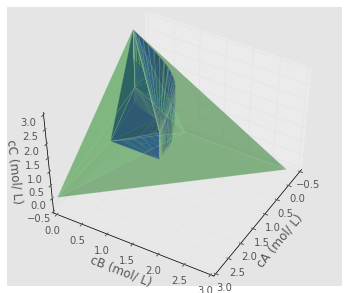

In [21]:
fig1 = artools.plot_region3d(Pk, color='b', alpha=0.4)
ax1 = fig1.gca()

fig2 = artools.plot_region3d(S, color='g', ax=ax1)

# label
ax1.set_xlabel('cA (mol/ L)')
ax1.set_ylabel('cB (mol/ L)')
ax1.set_zlabel('cC (mol/ L)')

plt.show(fig1)

In [22]:
rank_Pk = artools.rank(Pk)
rank_Pk

3

### I want to overlay the individual stoichio

In [24]:
S_attributes1 = stoich_subspace(Cf1, stoich_mat)
S1 = S_attributes1['all_Cs_mat']
S1

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:99: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:100: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([[  0.00000000e+00,   1.11022302e-16,   1.00000000e+00],
       [  1.00000000e+00,   5.55111512e-17,  -5.55111512e-17],
       [  0.00000000e+00,   1.00000000e+00,   0.00000000e+00]])

In [25]:
S_attributes2 = stoich_subspace(Cf2, stoich_mat)
S2 = S_attributes2['all_Cs_mat']
S2

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:99: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:100: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([[  0.00000000e+00,   4.44089210e-16,   2.00000000e+00],
       [  2.00000000e+00,   1.11022302e-16,   0.00000000e+00],
       [  0.00000000e+00,   2.00000000e+00,   0.00000000e+00]])

In [26]:
S_attributes3 = stoich_subspace(Cf3, stoich_mat)
S3 = S_attributes3['all_Cs_mat']
S3

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:99: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:100: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([[ -4.44089210e-16,   6.66133815e-16,   3.00000000e+00],
       [  3.00000000e+00,   2.22044605e-16,   0.00000000e+00],
       [  1.11022302e-16,   3.00000000e+00,   0.00000000e+00]])